In [1]:
from collections import deque

from sortedcontainers import SortedDict

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
from numba import njit

from matplotlib import pyplot as plt

In [3]:
def Min(iterable):
    res = np.inf
    for x in iterable:
        res = min(x, res)
    return res

def Max(iterable):
    res = -np.inf
    for x in iterable:
        res = max(x, res)
    return res

In [4]:
from dataclasses import dataclass
from typing import Optional
from typing import Tuple
from typing import List


@dataclass
class Order:  # Our own placed order
    timestamp: int    
    order_id: int
    side: str
    size: float
    price: float

        
@dataclass
class DeleteOrder:
    timestamp: int
    id_to_delete : int

@dataclass
class AnonTrade:  # Market trade
    exchange_ts : int
    receive_ts : int
    side: str
    size: float
    price: float


@dataclass
class OwnTrade:  # Execution of own placed order
    exchange_ts: int
    receive_ts: int
    trade_id: int
    order_id: int
    side: str
    size: float
    price: float


@dataclass
class OrderbookSnapshotUpdate:  # Orderbook tick snapshot
    exchange_ts : int
    receive_ts : int
    asks: List[Tuple[float, float]]  # tuple[price, size]
    bids: List[Tuple[float, float]]


@dataclass
class MdUpdate:  # Data of a tick
    exchange_ts : int
    receive_ts : int
    orderbook: Optional[OrderbookSnapshotUpdate] = None
    trade: Optional[AnonTrade] = None

In [5]:
import pandas as pd

In [6]:
def load_trades(path, nrows=10000) -> List[AnonTrade]:
    trades = pd.read_csv(path + 'trades.csv', nrows=nrows)
    
    #переставляю колонки, чтобы удобнее подавать их в конструктор AnonTrade
    trades = trades[ ['exchange_ts', 'receive_ts', 'aggro_side', 'size', 'price' ] ].sort_values(["exchange_ts", 'receive_ts'])
    receive_ts = trades.receive_ts.values
    exchange_ts = trades.exchange_ts.values 
    trades = [ AnonTrade(*args) for args in trades.values]
    md = [ MdUpdate(  exchange_ts[i], receive_ts[i], None, trades[i]) for i in range(len(trades)) ]
    return md

In [7]:
def load_books(path, nrows=10000) -> List[OrderbookSnapshotUpdate]:
    lobs   = pd.read_csv(path + 'lobs.csv', nrows=nrows)
    
    #rename columns
    names = lobs.columns.values
    ln = len('btcusdt:Binance:LinearPerpetual_')
    renamer = { name:name[ln:] for name in names[2:]}
    renamer[' exchange_ts'] = 'exchange_ts'
    lobs.rename(renamer, axis=1, inplace=True)
    
    #timestamps
    receive_ts = lobs.receive_ts.values
    exchange_ts = lobs.exchange_ts.values 
    #список ask_price, ask_vol для разных уровней стакана
    #размеры: len(asks) = 10, len(asks[0]) = len(lobs)
    asks = [list(zip(lobs[f"ask_price_{i}"],lobs[f"ask_vol_{i}"])) for i in range(10)]
    #транспонируем список
    asks = [ [asks[i][j] for i in range(len(asks))] for j in range(len(asks[0]))]
    #тоже самое с бидами
    bids = [list(zip(lobs[f"bid_price_{i}"],lobs[f"bid_vol_{i}"])) for i in range(10)]
    bids = [ [bids[i][j] for i in range(len(bids))] for j in range(len(bids[0]))]
    
    book = list( OrderbookSnapshotUpdate(*args) for args in zip(exchange_ts, receive_ts, asks, bids) )
    md = [ MdUpdate(exchange_ts[i], receive_ts[i], book[i], None) for i in range(len(book)) ]
    return md

In [8]:
def load_md_from_file(path: str, nrows=10000) -> List[MdUpdate]:
    md_trades = load_trades(path, nrows)
    md_books  = load_books(path, nrows)
    md = sorted( md_trades + md_books, key=lambda x: x.receive_ts )
    return md

In [9]:
def update_best_positions(best_bid:float, best_ask:float, md:MdUpdate):
    if not md.orderbook is None:
        best_bid = md.orderbook.bids[0][0]
        best_ask = md.orderbook.asks[0][0]
    elif not md.trade is None:
        if md.trade.side == 'BID':
            best_ask = md.trade.price
        else:
            best_bid = md.trade.price
    return best_bid, best_ask

In [10]:
class Sim:
    def __init__(self, execution_latency: float, md_latency: float, nrows : int) -> None:
        #nrows -- сколько строк маркет даты скачивать   
        self.md_queue = deque(load_md_from_file('../md/btcusdt:Binance:LinearPerpetual/', nrows))
        
        self.actions_queue = deque()
        #SordetDict: receive_ts -> update
        self.strategy_updates_queue = SortedDict()
        
        #map : order_id -> Order
        self.ready_to_execute_orders = {}
        
        #current md
        self.md = None
        #current ids
        self.order_id = 0
        self.trade_id = 0
        #latency
        self.latency = execution_latency * 1000
        self.md_latency = md_latency * 1000
        #current bid and ask
        self.best_bid = -np.inf
        self.best_ask = np.inf
        
    
    def get_md_queue_event_time(self):
        return np.inf if len(self.md_queue) == 0 else self.md_queue[0].exchange_ts
    
    
    def get_actions_queue_event_time(self):
        return np.inf if len(self.actions_queue) == 0 else self.actions_queue[0].timestamp
    
    
    def get_strategy_updates_queue_event_time(self):
        return np.inf if len(self.strategy_updates_queue) == 0 else \
            self.strategy_updates_queue[self.strategy_updates_queue.keys()[0]].receive_ts
    
    
    def get_order_id(self):
        res = self.order_id
        self.order_id += 1
        return res
    
    
    def get_trade_id(self):
        res = self.trade_id
        self.trade_id += 1
        return res
    
    
    def place_order(self, ts, size, side, price):
        #добавляем заявку в список всех заявок
        #ts равен времени, когда заявка придет на биржу
        ts += self.latency
        order = Order(ts, self.get_order_id(), side, size, price)
        self.actions_queue.append(order)
        return order

    
    def cancel_order(self, ts, id_to_delete):
        #добавляем заявку на удаление
        ts += self.latency
        delete_order = DeleteOrder(ts, id_to_delete)
        self.actions_queue.append(delete_order)
        return delete_order
    
    
    def update_md(self, md):        
        #current md
        self.md = md
        self.best_bid, self.best_ask = update_best_positions(self.best_bid, self.best_ask, md) 
        self.strategy_updates_queue[md.receive_ts] = md
        
    
    def update_action(self, action):
        if isinstance(action, Order):
            self.ready_to_execute_orders[action.order_id] = action
        elif isinstance(action, CancelOrder):
            #удаляем ордер из списка отстоявшихся стратегий
            if action.id_to_delete in self.ready_to_execute_orders:
                self.ready_to_execute_orders.pop(action.id_to_delete)
        else:
            assert False, "Wrong action type!"

        
    def tick(self):
        
        while True:
            self.execute_orders()
            strategy_updates_queue_et = self.get_strategy_updates_queue_event_time()
            md_queue_et = self.get_md_queue_event_time()
            actions_queue_et = self.get_actions_queue_event_time()
            
            #both queue are empty
            if md_queue_et == np.inf and actions_queue_et == np.inf:
                break
            #strategy queue has minimum event time
            if min(md_queue_et, actions_queue_et) > strategy_updates_queue_et:
                break
            if md_queue_et < actions_queue_et:
                self.update_md( self.md_queue.popleft() )
            elif actions_queue_et < np.inf:
                self.update_action( self.actions_queue.popleft() )
        if len(self.strategy_updates_queue) == 0:
            return None
        res = self.strategy_updates_queue.pop(self.strategy_updates_queue.keys()[0])
        assert res.receive_ts <= self.md.receive_ts
        return res


    def execute_orders(self):
        executed_orders_id = []
        for order_id, order in self.ready_to_execute_orders.items():
            executed_order = None
            if order.side == 'BID' and order.price >= self.best_ask:
                executed_order = OwnTrade(
                    self.md.exchange_ts, 
                    self.md.exchange_ts + self.md_latency,
                    self.get_trade_id(),
                    order_id,
                    order.side,
                    order.size,
                    self.best_ask,
                )
            if order.side == 'ASK' and order.price <= self.best_bid:
                executed_order = OwnTrade(
                    self.md.exchange_ts, 
                    self.md.exchange_ts + self.md_latency,
                    self.get_trade_id(),
                    order_id,
                    order.side,
                    order.size,
                    self.best_bid,
                )
            if not executed_order is None:
                executed_orders_id.append(order_id)
                self.strategy_updates_queue[ executed_order.receive_ts ] = executed_order
        for k in executed_orders_id:
            self.ready_to_execute_orders.pop(k)
        pass

In [11]:
class BestPosStrategy:
    '''
        стратегия выставляет best_bid, best_ask заявки каждую миллисекунду
    '''
    def __init__(self, max_position: float) -> None:
        self.max_pos = max_position

    def run(self, sim: "Sim"):
        
        
        #список для маркет даты
        md_list = []
        #список для трейдов
        trades_list = []
        #список для update
        updates_list = []
        
        best_bid = -np.inf
        best_ask = np.inf
        
        #задержка между подачами заявки
        dt = 10000
        #время предыдущей заявки
        prev_time = 0
        
        while True:
            update = sim.tick()
            if update is None:
                break
            updates_list.append(update)
            if isinstance(update, MdUpdate):
                best_bid, best_ask = update_best_positions(best_bid, best_ask, update)
                md_list.append(update)
            elif isinstance(update, OwnTrade):
                trades_list.append(update)      
            else:
                assert False, 'invalid type of update!'
            
            if update.receive_ts - prev_time >= dt:
                prev_time = update.receive_ts
                
                sim.place_order( update.receive_ts, 0.001, 'BID', best_bid )
                sim.place_order( update.receive_ts, 0.001, 'ASK', best_ask )
                
        return trades_list, md_list, updates_list

In [12]:
def GetPnL(updates_list):

    btc_pos, usd_pos = 0.0, 0.0
    
    worth = 0.0
    
    worth_list = []
    btc_pos_list = []
    usd_pos_list = []
    mid_price_list = []
    
    best_bid = -np.inf
    best_ask = np.inf

    for update in updates_list:
        
        if isinstance(update, MdUpdate):
            best_bid, best_ask = update_best_positions(best_bid, best_ask, update)
        
        mid_price = 0.5 * ( best_ask + best_bid )
        
        if isinstance(update, OwnTrade):
            trade = update    
            #update positions
            if trade.side == 'BID':
                btc_pos += trade.size
                usd_pos -= trade.price * trade.size
            elif trade.side == 'ASK':
                btc_pos -= trade.size
                usd_pos += trade.price * trade.size
        
        worth = usd_pos + mid_price * btc_pos
        worth_list.append(worth)
        btc_pos_list.append(btc_pos)
        usd_pos_list.append(usd_pos)
        mid_price_list.append(mid_price)
    receive_ts = [update.receive_ts for update in updates_list]
    exchange_ts = [update.exchange_ts for update in updates_list]
    df = pd.DataFrame({"exchange_ts": exchange_ts, "receive_ts":receive_ts, "total":worth_list, "BTC":btc_pos_list, 
                       "USD":usd_pos_list, "mid_price":mid_price_list})
    return df

In [13]:
def trade_to_dataframe(trades_list):
    exchange_ts = [ trade.exchange_ts for trade in trades_list ]
    receive_ts = [ trade.receive_ts for trade in trades_list ]
    
    size = [ trade.size for trade in trades_list ]
    price = [ trade.price for trade in trades_list ]
    side  = [trade.side for trade in trades_list ]
    
    dct = {
        "exchange_ts" : exchange_ts,
        "receive_ts"  : receive_ts,
         "size" : size,
        "price" : price,
        "side"  : side
    }
    
    df = pd.DataFrame(dct)
    
    return df


def md_to_dataframe(md_list):
    
    best_bid = -np.inf
    best_ask = np.inf
    best_bids = []
    best_asks = []
    for md in md_list:
        best_bid, best_ask = update_best_positions(best_bid, best_ask, md)
        
        best_bids.append(best_bid)
        best_asks.append(best_ask)
        
    exchange_ts = [ md.exchange_ts for md in md_list ]
    receive_ts = [ md.receive_ts for md in md_list ]
    dct = {
        "exchange_ts" : exchange_ts,
        "receive_ts"  :receive_ts,
        "bid_price" : best_bids,
        "ask_price" : best_asks
    }
    
    df = pd.DataFrame(dct)    
    return df

In [14]:
NROWS = 100000

In [15]:
strategy = BestPosStrategy(10)

In [16]:
sim = Sim(100, 100, NROWS)

strategy = BestPosStrategy(10)

In [17]:
trades_list, md_list, updates_list = strategy.run(sim)

In [18]:
trades, mds = trade_to_dataframe(trades_list), md_to_dataframe(md_list)

In [19]:
df = GetPnL(updates_list)

In [20]:
dt = pd.to_datetime(df.receive_ts)

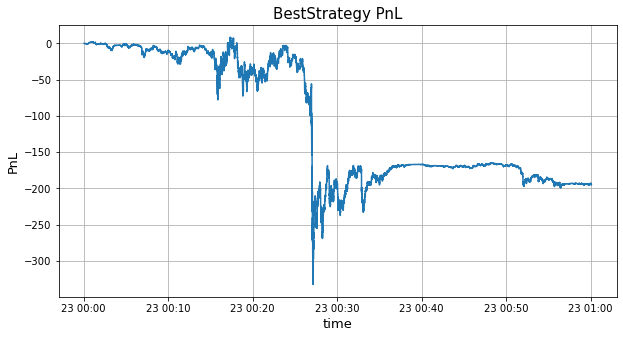

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(dt, df.total, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("BestStrategy PnL", fontsize=15)
plt.grid()